# Kinetic Monte Carlo Simulation of Lignin Polymerization
Written by: Michael Orella <br>
24 January 2019 <br>

The code in this notebook performs calculations analogous to those performed in [citation here], which depends on the results that were obtained from [DFT Calculations of monolignol coupling kinetics](https://chemrxiv.org/articles/Quantum_Mechanical_Calculations_Suggest_That_Lignin_Polymerization_Is_Kinetically_Controlled/7334564).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#LIGNIN-KMC Package
import ligninkmc as kmc

#General Math and LinAlg
import numpy as np
import scipy as sp
import scipy.optimize

#Chemical Drawing
from rdkit import Chem
from rdkit.Chem import AllChem
from IPython.display import SVG

#Plotting
import matplotlib.pyplot as plt

#Profiling and Performance
import cProfile
import time

#Parallelization
import joblib as par

## Input Data
The kinetic monte carlo code relies on rates of chemical reactions. The reactions that we are interested in here are the coupling of radicals on either individual monomers or oligomers respectively. The energetics necessary to compute the reaction rates were performed by Terry Gani using [DFT methods](https://chemrxiv.org/articles/Quantum_Mechanical_Calculations_Suggest_That_Lignin_Polymerization_Is_Kinetically_Controlled/7334564) for SG lignin and similar methods for C lignin. Once the reaction energies were calculated, they could be inputted using the Erying equation to obtain the actual rate.
$$ r_i = \dfrac{k_BT}{h}\exp\left(-\dfrac{\Delta G_i}{k_BT}\right) $$

Throughout the code, monomers are kept track of individually through the state, so there are no reaction degeneracies occuring, and bond events can be tracked faithfully.

In [3]:
kb = 1.38064852e-23 # J / K
h = 6.62607004e-34 # J s
temp = 298.15 #K
kcalToJoule = 4184 / 6.022140857e23

#Input energy information
#Select which energy set you want to use
energies = {'5o4':{(0,0):{('monomer','monomer'):11.2,('monomer','dimer'):14.6,
                          ('dimer','monomer'):14.6,('dimer','dimer'):4.4},
                   (1,0):{('monomer','monomer'):10.9,('monomer','dimer'):14.6,
                          ('dimer','monomer'):14.6,('dimer','dimer'):4.4}},
            '55':{(0,0):{('monomer','monomer'):12.5,('monomer','dimer'):15.6,
                          ('dimer','monomer'):15.6,('dimer','dimer'):3.8}},
            'b5':{(0,0):{('monomer','monomer'):5.5,('monomer','dimer'):5.8,
                          ('dimer','monomer'):5.8,('dimer','dimer'):5.8},
                  (0,1):{('monomer','monomer'):5.5,('monomer','dimer'):5.8,
                          ('dimer','monomer'):5.8,('dimer','dimer'):5.8}},
            'bb':{(0,0):{('monomer','monomer'):5.2,('monomer','dimer'):5.2,('dimer','monomer'):5.2,('dimer','dimer'):5.2},
                  (1,0):{('monomer','monomer'):6.5,('monomer','dimer'):6.5,('dimer','monomer'):6.5,('dimer','dimer'):6.5},
                  (1,1):{('monomer','monomer'):5.2,('monomer','dimer'):5.2,('dimer','monomer'):5.2,('dimer','dimer'):5.2}},
            'bo4':{(0,0):{('monomer','monomer'):6.3,('monomer','dimer'):6.2,
                          ('dimer','monomer'):6.2,('dimer','dimer'):6.2},
                   (1,0):{('monomer','monomer'):9.1,('monomer','dimer'):6.2,
                          ('dimer','monomer'):6.2,('dimer','dimer'):6.2},
                   (0,1):{('monomer','monomer'):8.9,('monomer','dimer'):6.2,
                          ('dimer','monomer'):6.2,('dimer','dimer'):6.2},
                   (1,1):{('monomer','monomer'):9.8,('monomer','dimer'):10.4,
                          ('dimer','monomer'):10.4}},
            'ao4':{(0,0):{('monomer','monomer'):20.7,('monomer','dimer'):20.7,
                          ('dimer','monomer'):20.7,('dimer','dimer'):20.7},
                   (1,0):{('monomer','monomer'):20.7,('monomer','dimer'):20.7,
                          ('dimer','monomer'):20.7,('dimer','dimer'):20.7},
                   (0,1):{('monomer','monomer'):20.7,('monomer','dimer'):20.7,
                          ('dimer','monomer'):20.7,('dimer','dimer'):20.7},
                   (1,1):{('monomer','monomer'):20.7,('monomer','dimer'):20.7,
                          ('dimer','monomer'):20.7,('dimer','dimer'):20.7}},
            'b1':{(0,0):{('monomer','dimer'):9.6,
                          ('dimer','monomer'):9.6,('dimer','dimer'):9.6},
                  (1,0):{('monomer','dimer'):11.7,
                          ('dimer','monomer'):11.7,('dimer','dimer'):11.7},
                  (0,1):{('monomer','dimer'):10.7,
                          ('dimer','monomer'):10.7,('dimer','dimer'):10.7},
                  (1,1):{('monomer','dimer'):11.9,
                          ('dimer','monomer'):11.9,('dimer','dimer'):11.9}},
            'ox':{0:{'monomer':0.9,'dimer':6.3},1:{'monomer':0.6,'dimer':2.2}},
            'q':{0:{'monomer':11.1,'dimer':11.1},1:{'monomer':11.7,'dimer':11.7}}}
energies['bb'][(0,1)] = energies['bb'][(1,0)]

#Correct units of the energies
energiesev = {bond : {monType : {size : energies[bond][monType][size] * kcalToJoule for size in energies[bond][monType]}
                    for monType in energies[bond] } 
            for bond in energies }

#Calculate the rates of reaction
rates = {bond : {monType : { size : kb * temp / h * np.exp ( - energiesev[bond][monType][size] / kb / temp ) 
                            for size in energies[bond][monType]} 
                 for monType in energies[bond] } #Make rates 1/ns instead of 1/s
         for bond in energies}

While the above energies were calculated for S and G monomers, there will be differences for the coupling of C monomers

In [4]:
cLigEnergies = {'5o4':{(2,2):{('monomer','monomer'):11.9,('monomer','dimer'):11.9,
                          ('dimer','monomer'):11.9,('dimer','dimer'):11.9}},
            '55':{(2,2):{('monomer','monomer'):10.6,('monomer','dimer'):10.6,
                          ('dimer','monomer'):10.6,('dimer','dimer'):10.6}},
            'b5':{(2,2):{('monomer','monomer'):1.9,('monomer','dimer'):5.8,
                          ('dimer','monomer'):5.8,('dimer','dimer'):5.8}},
            'bb':{(2,2):{('monomer','monomer'):7.2,('monomer','dimer'):7.2,
                         ('dimer','monomer'):7.2,('dimer','dimer'):7.2}},
            'bo4':{(2,2):{('monomer','monomer'):4.9,('monomer','dimer'):1.3,
                          ('dimer','monomer'):1.3,('dimer','dimer'):1.3}},
            'ao4':{(2,2):{('monomer','monomer'):20.7,('monomer','dimer'):20.7,
                          ('dimer','monomer'):20.7,('dimer','dimer'):20.7}},
            'b1':{(2,2):{('monomer','dimer'):9.6,
                          ('dimer','monomer'):9.6,('dimer','dimer'):9.6}},
            'ox':{2:{'monomer':0.9,'dimer':0.9}},
            'q':{2:{'monomer':11.1,'dimer':11.1}}}

#Correct units of the energies
cLigEnergiesev = {bond : {monType : {size : cLigEnergies[bond][monType][size] * kcalToJoule for size in cLigEnergies[bond][monType]}
                    for monType in cLigEnergies[bond] }
            for bond in cLigEnergies }

#Calculate the rates of reaction
cRates = {bond : {monType : { size : kb * temp / h * np.exp ( - cLigEnergiesev[bond][monType][size] / kb / temp ) 
                            for size in cLigEnergies[bond][monType] } 
                 for monType in cLigEnergies[bond] } #Make rates 1/ns instead of 1/s
         for bond in cLigEnergies}

## Code Performance
One of the first things that we were interested in reporting was the performance and scaling of this code package. This was done by replicating runs of the algorithm with different numbers of monomers included in the simulation under batch conditions.

In [5]:
times = []

sg = 1

pct = sg / (1 + sg)

testvals = np.linspace(50,150,num=3,dtype = 'int32')
Nrepeats = 5
for Nmon in testvals:
    times.append([])
    for _ in range(Nrepeats):
        #Generate the initial monomers
        rands = np.random.rand(Nmon)
        mons = [ kmc.Monomer( int ( sOrG < pct ) , i ) for i,sOrG in zip ( range(Nmon) , rands ) ]
        startEvents = [ kmc.Event ( 'ox' , [i] , rates['ox'][ int( sOrG < pct ) ]['monomer'] ) for i,sOrG in zip ( range(Nmon) , rands) ]

        #Set the initial state and events
        state = { i : {'mon' : mons[i] , 'affected' : {startEvents[i]} } for i in range(Nmon) }
        events = { startEvents[i] for i in range(Nmon) }
        
        #Start timing the actual KMC part
        start = time.time()
        kmc.run(tFinal = 1e9, rates = rates, initialState = state, initialEvents = events)
        end = time.time()
        times[-1].append(end-start)
    print(f'Time to complete simulation with {Nmon:5n} monomers: {np.sum(times[-1])/Nrepeats:7.2f} seconds')

Time to complete simulation with    50 monomers:    3.68 seconds
Time to complete simulation with   100 monomers:   18.53 seconds
Time to complete simulation with   150 monomers:   34.74 seconds


Now we want to fit the times that we just calculated to a generic power law expression $t = aN^b$ to find the scaling of our algorithm.

In [6]:
meas_t = [np.mean(time) for time in times]
meas_n = testvals

sim_t = lambda p,n : p[0] * np.power (n , p[1])
loss = lambda p: np.linalg.norm(sim_t(p,meas_n) - meas_t)

res = sp.optimize.minimize(loss, [1e-5,2.5] , bounds = [[0,1],[0,10]],options = {'disp':True})
print(res)

opt_p = res.x

      fun: 1.956581720529934
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.19202375, -0.03416951])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 282
      nit: 63
   status: 0
  success: True
        x: array([0.005666  , 1.74267317])


Now we should plot both the measured values and the fit all together

Text(200,200,'Measured')

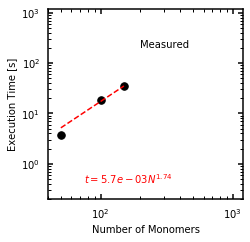

In [7]:
plt.figure(figsize=(3.5,3.5))
plt.errorbar(testvals,[np.mean(time) for time in times],
             yerr=[np.sqrt(np.var(time)) for time in times],
             capsize=3,ecolor='black',linestyle='None',marker='.',markerSize=15,color='black',zorder=1)
plt.plot(testvals,sim_t(opt_p,meas_n),linestyle='--',color='r',linewidth=1.5,zorder=2)
plt.tick_params(axis = 'both',which = 'major', labelsize = 10, direction = 'in',
               pad = 8, top = True, right = True, width = 1.5, length = 5)
plt.tick_params(axis = 'both',which = 'minor', direction = 'in',
               pad = 8, top = True, right = True, width = 1, length = 3)
ax = plt.gca()
[ax.spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
ax.fontsize = 10
plt.xlabel('Number of Monomers',fontsize=10)
plt.ylabel('Execution Time [s]',fontsize=10)
plt.yscale('log')
plt.xscale('log')
plt.ylim([0.2,1200])
plt.xlim([40,1200])
plt.text(75,0.4,f'$t = {opt_p[0]:3.1e}N^{{ {opt_p[1]:4.2f} }}$',fontsize=10,color='red')
plt.text(200,200,r'Measured',fontsize=10,color='black')
#plt.savefig('../plots/performance.svg',format='svg',transparent=True,bbox_inches='tight')

## Example KMC Runs
Small examples of running the algorithm for KMC, using both SG lignin and C lignin.

### SG Lignin
Run an example starting with 2 monomers and an S to G ratio of 1

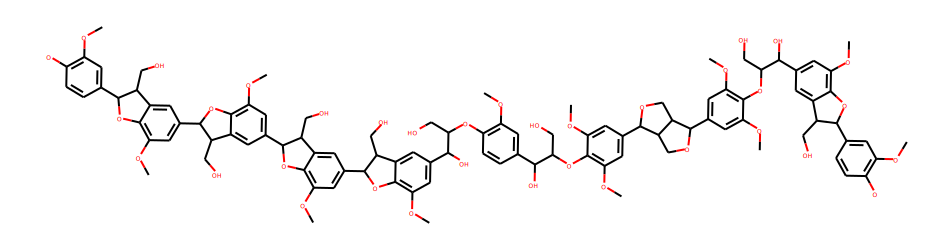

In [8]:
sg = 1
n = 2

pct = sg / (1 + sg)

rands = np.random.rand(n)
mons = [ kmc.Monomer( int ( sOrG < pct ) , i ) for i,sOrG in zip ( range(n) , rands ) ]
startEvents = [ kmc.Event ( 'ox' , [i] , rates['ox'][ int( sOrG < pct ) ]['monomer'] ) for i,sOrG in zip ( range(n) , rands) ]

state = { i : {'mon' : mons[i] , 'affected' : {startEvents[i]} } for i in range(n) }
events = { startEvents[i] for i in range(n) }
events.add(kmc.Event('grow',[],rate = 1e4,bond = sg))

res = kmc.run(nMax = 10,tFinal = 1, rates = rates, initialState = state, initialEvents = events)
nodes = res['monomers']
adj = res['adjacency_matrix']

block = kmc.generateMol(adj,nodes)
mol = Chem.MolFromMolBlock(block)
AllChem.Compute2DCoords(mol)
SVG(kmc.moltosvg(mol,molSize=(950,250)))

### C lignin
Run an example with 2 monomers but using the C lignin energies

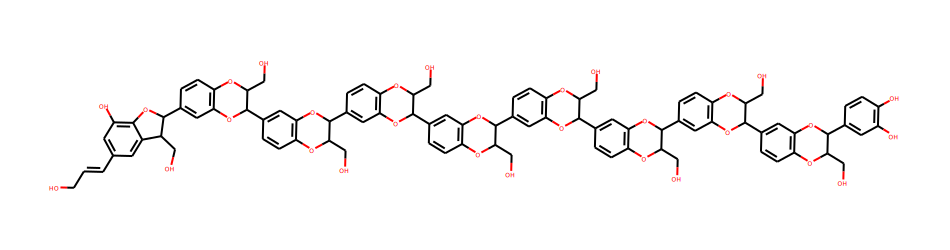

In [9]:
n = 2

mons = [ kmc.Monomer( 2 , i ) for i in range(n) ]
startEvents = [ kmc.Event ( 'ox' , [i] , cRates['ox'][ 2 ]['monomer'] ) for i in range(n) ]

state = { i : {'mon' : mons[i] , 'affected' : {startEvents[i]} } for i in range(n)}
events = { startEvents[i] for i in range(n)}
events.add(kmc.Event('grow',[],rate=1e0))

res = kmc.run(nMax = 10,tFinal = 1000, rates = cRates, initialState = state, initialEvents = events)
nodes = res['monomers']
adj = res['adjacency_matrix']

block = kmc.generateMol(adj,nodes)
mol = Chem.MolFromMolBlock(block)
AllChem.Compute2DCoords(mol)
SVG(kmc.moltosvg(mol,molSize=(950,250)))

## Sensitivity Analyses Examples
The meat of the results and discussion for our paper lay in the predictions of how lignin composition should change with different sets of parameters used for lignification. These calculations were performed on desktop hardware over about a week's period, but for the sake of explanation, shorter examples are used here. We investigated the impact of S to G ratio and addition rate primarily.

### SG Batch Sensitivity
The first analysis performed is the dependence of monomer yields and bond contents on SG ratio, where we selected multiple SG ratios between 0.1 and 10 and ran the simulations for these scenarios.

In [10]:
sg_opts = [0.1,0.2,0.25,0.33,0.5,1,2,3,4,5,10]

fun = par.delayed(kmc.run)
resultsToSave = []
     
for sg in sg_opts:
    #Set the percentage of S
    pct = sg / (1 + sg)
    
    #Make choices about what kinds of monomers there are
    n = 200
    rands = np.random.rand(n)
    
    #Initialize the monomers, events, and state
    mons = [ kmc.Monomer( int ( sOrG < pct ) , i ) for i,sOrG in zip ( range(n) , rands ) ]
    startEvents = [ kmc.Event ( 'ox' , [i] , rates['ox'][ int( sOrG < pct ) ]['monomer'] ) for i,sOrG in zip ( range(n) , rands) ]

    state = { i : {'mon' : mons[i] , 'affected' : {startEvents[i]} } for i in range(n) }
    events = { startEvents[i] for i in range(n) }

    results = par.Parallel(n_jobs = 4)([fun(nMax = 200, tFinal = 1,rates = rates,initialState = state,initialEvents = events)
                                        for _ in range(5)])
    resultsToSave.append(results)
    print('Completed sensitivity iteration: ' + str(sg))

    t = time.localtime()
    print('Finished on ' + str(t.tm_year) + '-' + str(t.tm_mon) + '-' + str(t.tm_mday) 
            + ' at ' + str(t.tm_hour) + ':' + str(t.tm_min) + ':' + str(t.tm_sec))

Completed sensitivity iteration: 0.1
Finished on 2019-12-5 at 10:19:53
Completed sensitivity iteration: 0.2
Finished on 2019-12-5 at 10:23:18
Completed sensitivity iteration: 0.25
Finished on 2019-12-5 at 10:25:37
Completed sensitivity iteration: 0.33
Finished on 2019-12-5 at 10:30:13
Completed sensitivity iteration: 0.5
Finished on 2019-12-5 at 10:33:30
Completed sensitivity iteration: 1
Finished on 2019-12-5 at 10:36:31
Completed sensitivity iteration: 2
Finished on 2019-12-5 at 10:39:7
Completed sensitivity iteration: 3
Finished on 2019-12-5 at 10:42:26
Completed sensitivity iteration: 4
Finished on 2019-12-5 at 10:58:22
Completed sensitivity iteration: 5
Finished on 2019-12-5 at 11:3:35
Completed sensitivity iteration: 10
Finished on 2019-12-5 at 11:5:26


We must now aggregate the results that we obtained in the form of adjacency matrices and monomer lists and times to meaningful values of monomer yields and bond contents.

In [11]:
nodeRes = [0]*len(resultsToSave); adjRes = [0]*len(resultsToSave);
analysis = [0]*len(resultsToSave)
for i in range(len(resultsToSave)):
    nodeRes[i] = [resultsToSave[i][j]['monomers'] for j in range(len(resultsToSave[i]))]
    adjRes[i] = [resultsToSave[i][j]['adjacency_matrix'] for j in range(len(resultsToSave[i]))]
    
    analysis[i] = par.Parallel(n_jobs = 4)([par.delayed(kmc.analyze)
                                         (adjacency = adjRes[i][j],
                                          nodes = nodeRes[i][j]) 
                                         for j in range(len(resultsToSave[i]))])
    t = time.localtime()
    print('Finished on ',(str(t.tm_year) + '-' + str(t.tm_mon) + '-' 
                          + str(t.tm_mday)), 'at', 
         (str(t.tm_hour) + ':' + str(t.tm_min) + ':' + str(t.tm_sec)))

Finished on  2019-12-5 at 11:5:35
Finished on  2019-12-5 at 11:5:40
Finished on  2019-12-5 at 11:5:46
Finished on  2019-12-5 at 11:5:55
Finished on  2019-12-5 at 11:6:3
Finished on  2019-12-5 at 11:6:11
Finished on  2019-12-5 at 11:6:19
Finished on  2019-12-5 at 11:6:26
Finished on  2019-12-5 at 11:6:34
Finished on  2019-12-5 at 11:6:40
Finished on  2019-12-5 at 11:6:43


Now as an example, we will look at the distribution of monomer yields that we got, and then summarize that distribution with the sample mean and standard deviation, which will be used for all of the subsequent analyses. To visualize these results, we first need to extract the information from the analysis data structure, and normalize the data to the total number of monomers or total number of bonds.

In [12]:
nsens = len(analysis)
nrep = len(analysis[0])

nmon = [[sum([analysis[j][i]['Chain Lengths'][k]*k for k in analysis[j][i]['Chain Lengths']]) 
         for i in range(nrep)] for j in range(nsens)]

monomerYields = [[analysis[j][i]['RCF Yields'][1]/nmon[j][i] 
                  for i in range(nrep)] for j in range(nsens)]
betaO4Content = [[analysis[j][i]['Bonds']['bo4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
beta5Content = [[analysis[j][i]['Bonds']['b5']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
betabetaContent = [[analysis[j][i]['Bonds']['bb']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
beta1Content = [[analysis[j][i]['Bonds']['b1']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
fiveO4Content = [[analysis[j][i]['Bonds']['5o4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
alphaO4Content = [[analysis[j][i]['Bonds']['ao4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
fivefiveContent = [[analysis[j][i]['Bonds']['55']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]

av_monYield = [np.mean(hist) for hist in monomerYields]; std_monYield = [np.sqrt(np.var(hist)) for hist in monomerYields];
av_bo4Content = [np.mean(hist) for hist in betaO4Content]; std_bo4Content = [np.sqrt(np.var(hist)) for hist in betaO4Content];
av_b5Content = [np.mean(hist) for hist in beta5Content]; std_b5Content = [np.sqrt(np.var(hist)) for hist in beta5Content];
av_bbContent = [np.mean(hist) for hist in betabetaContent]; std_bbContent = [np.sqrt(np.var(hist)) for hist in betabetaContent];
av_b1Content = [np.mean(hist) for hist in beta1Content]; std_b1Content = [np.sqrt(np.var(hist)) for hist in beta1Content];
av_5o4Content = [np.mean(hist) for hist in fiveO4Content]; std_5o4Content = [np.sqrt(np.var(hist)) for hist in fiveO4Content];
av_ao4Content = [np.mean(hist) for hist in alphaO4Content]; std_ao4Content = [np.sqrt(np.var(hist)) for hist in alphaO4Content];
av_55Content = [np.mean(hist) for hist in fivefiveContent]; std_55Content = [np.sqrt(np.var(hist)) for hist in fivefiveContent];

With this aggregation complete, we now plot the histograms of monomer yields for 3 cases of SG ratios - 0.1, 1, and 10. With so few repeats, these histograms look very poor, but with greater repeats there is a much clearer trend and approximation of the normal distribution - which justifies the use of sample norm and standard deviation as summary statistics.

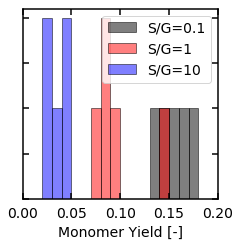

In [13]:
plt.figure(figsize=(3.5,3.5))
plt.hist(monomerYields[0],bins=np.linspace(0,0.2,21),density=1,facecolor='black',alpha=0.5,edgecolor='black',label='S/G=0.1')
plt.hist(monomerYields[5],bins=np.linspace(0,0.2,21),density=1,facecolor='red',alpha=0.5,edgecolor='black',label='S/G=1')
plt.hist(monomerYields[10],bins=np.linspace(0,0.2,21),density=1,facecolor='blue',alpha=0.5,edgecolor='black',label='S/G=10')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.xlim([0.0,0.2])
plt.gca().set_yticklabels(['']*len(plt.gca().get_yticklabels()))
plt.xlabel('Monomer Yield [-]',fontsize=14)
plt.legend(fontsize=14,loc='best');

As mentioned above, with more repeats these distributions approach the normal distribution. In addition, if we want to add more sensitivity results to this plot, it starts to look messier and more crowded. Therefore, it becomes much easier to use the mean and variance of our samples as summary statistics, and just plot these values (using the standard deviation as the error bar on every point).

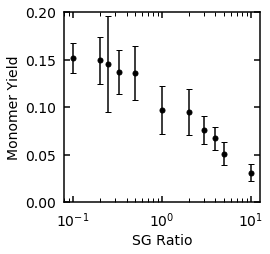

In [14]:
plt.figure(figsize=(3.5,3.5))
plt.errorbar(sg_opts,av_monYield,yerr = std_monYield,linestyle='none',marker='.',markersize=10,markerfacecolor='black',markeredgecolor='black',capsize=3,ecolor='black')
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('SG Ratio',fontsize=14)
plt.ylim([0.0,0.2]);

The monomer yields plot above is easy, because there is just one trend that we look at. For this instance, that trend is fairly messy, again because there are fewer repeats and fewer monomers in each simulation, but the idea is still the same.

Let us now examine the bond contents that were predicted from this simulation.

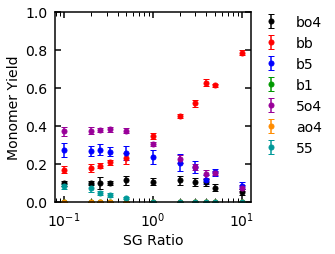

In [15]:
colors = [(0,0,0),(1,0,0),(0,0,1),(0,0.6,0),(0.6,0,0.6),(1,0.5490,0),(0,0.6,0.6),(1,0.8,0),(0.6078,0.2980,0),
         (0.6,0,0),(0,0,0.6)]
plt.figure(figsize=(3.5,3.5))
plt.errorbar(sg_opts,av_bo4Content,yerr = std_bo4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[0],markeredgecolor=colors[0],label='bo4',capsize=3,ecolor=colors[0])
plt.errorbar(sg_opts,av_bbContent,yerr = std_bbContent,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[1],markeredgecolor=colors[1],label='bb',capsize=3,ecolor=colors[1])
plt.errorbar(sg_opts,av_b5Content,yerr = std_b5Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[2],markeredgecolor=colors[2],label='b5',capsize=3,ecolor=colors[2])
plt.errorbar(sg_opts,av_b1Content,yerr = std_b1Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[3],markeredgecolor=colors[3],label='b1',capsize=3,ecolor=colors[3])
plt.errorbar(sg_opts,av_5o4Content,yerr = std_5o4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[4],markeredgecolor=colors[4],label='5o4',capsize=3,ecolor=colors[4])
plt.errorbar(sg_opts,av_ao4Content,yerr = std_ao4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[5],markeredgecolor=colors[5],label='ao4',capsize=3,ecolor=colors[5])
plt.errorbar(sg_opts,av_55Content,yerr = std_55Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[6],markeredgecolor=colors[6],label='55',capsize=3,ecolor=colors[6])
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('SG Ratio',fontsize=14)
plt.ylim([0.0,1.0])
plt.legend(fontsize=14,loc='upper center',bbox_to_anchor=(1.2,1.05),frameon=False);

### Addition rate sensitivity
We will now perform the same task on different addition rates

In [16]:
addrates = np.logspace(4,14,21)

fun = par.delayed(kmc.run)
resultsToSave = []
     
for rate in addrates:
    #Set the percentage of S
    sg = 1
    pct = sg / (1 + sg)
    
    #Make choices about what kinds of monomers there are
    n = 5
    rands = np.random.rand(n)
    
    #Initialize the monomers, events, and state
    mons = [ kmc.Monomer( int ( sOrG < pct ) , i ) for i,sOrG in zip ( range(n) , rands ) ]
    startEvents = [ kmc.Event ( 'ox' , [i] , rates['ox'][ int( sOrG < pct ) ]['monomer'] ) for i,sOrG in zip ( range(n) , rands) ]

    state = { i : {'mon' : mons[i] , 'affected' : {startEvents[i]} } for i in range(n) }
    events = { startEvents[i] for i in range(n) }
    events.add(kmc.Event('grow',[],rate = rate,bond = sg))

    results = par.Parallel(n_jobs = 4)([fun(nMax = 200, tFinal = 1,rates = rates,initialState = state,initialEvents = events)
                                        for _ in range(5)])
    resultsToSave.append(results)
    print('Completed sensitivity iteration: ' + str(rate))

    t = time.localtime()
    print('Finished on ' + str(t.tm_year) + '-' + str(t.tm_mon) + '-' + str(t.tm_mday) 
            + ' at ' + str(t.tm_hour) + ':' + str(t.tm_min) + ':' + str(t.tm_sec))

Completed sensitivity iteration: 10000.0
Finished on 2019-12-5 at 11:6:57
Completed sensitivity iteration: 31622.776601683792
Finished on 2019-12-5 at 11:7:8
Completed sensitivity iteration: 100000.0
Finished on 2019-12-5 at 11:7:22
Completed sensitivity iteration: 316227.7660168379
Finished on 2019-12-5 at 11:7:43
Completed sensitivity iteration: 1000000.0
Finished on 2019-12-5 at 11:8:8
Completed sensitivity iteration: 3162277.6601683795
Finished on 2019-12-5 at 11:8:43
Completed sensitivity iteration: 10000000.0
Finished on 2019-12-5 at 11:9:10
Completed sensitivity iteration: 31622776.60168379
Finished on 2019-12-5 at 11:11:6
Completed sensitivity iteration: 100000000.0
Finished on 2019-12-5 at 11:12:13
Completed sensitivity iteration: 316227766.01683795
Finished on 2019-12-5 at 11:13:3
Completed sensitivity iteration: 1000000000.0
Finished on 2019-12-5 at 11:13:48
Completed sensitivity iteration: 3162277660.1683793
Finished on 2019-12-5 at 11:15:46
Completed sensitivity iteration:

In [17]:
nodeRes = [0]*len(resultsToSave); adjRes = [0]*len(resultsToSave);
analysis = [0]*len(resultsToSave)
for i in range(len(resultsToSave)):
    nodeRes[i] = [resultsToSave[i][j]['monomers'] for j in range(len(resultsToSave[i]))]
    adjRes[i] = [resultsToSave[i][j]['adjacency_matrix'] for j in range(len(resultsToSave[i]))]
    
    analysis[i] = par.Parallel(n_jobs = 4)([par.delayed(kmc.analyze)
                                         (adjacency = adjRes[i][j],
                                          nodes = nodeRes[i][j]) 
                                         for j in range(len(resultsToSave[i]))])
    t = time.localtime()
    print('Finished on ',(str(t.tm_year) + '-' + str(t.tm_mon) + '-' 
                          + str(t.tm_mday)), 'at', 
         (str(t.tm_hour) + ':' + str(t.tm_min) + ':' + str(t.tm_sec)))

Finished on  2019-12-5 at 11:28:19
Finished on  2019-12-5 at 11:28:22
Finished on  2019-12-5 at 11:28:25
Finished on  2019-12-5 at 11:28:28
Finished on  2019-12-5 at 11:28:32
Finished on  2019-12-5 at 11:28:35
Finished on  2019-12-5 at 11:28:38
Finished on  2019-12-5 at 11:28:41
Finished on  2019-12-5 at 11:28:44
Finished on  2019-12-5 at 11:28:48
Finished on  2019-12-5 at 11:28:51
Finished on  2019-12-5 at 11:28:54
Finished on  2019-12-5 at 11:28:56
Finished on  2019-12-5 at 11:28:59
Finished on  2019-12-5 at 11:29:2
Finished on  2019-12-5 at 11:29:5
Finished on  2019-12-5 at 11:29:8
Finished on  2019-12-5 at 11:29:11
Finished on  2019-12-5 at 11:29:14
Finished on  2019-12-5 at 11:29:17
Finished on  2019-12-5 at 11:29:20


In [18]:
nsens = len(analysis)
nrep = len(analysis[0])

nmon = [[sum([analysis[j][i]['Chain Lengths'][k]*k for k in analysis[j][i]['Chain Lengths']]) 
         for i in range(nrep)] for j in range(nsens)]

monomerYields = [[analysis[j][i]['RCF Yields'][1]/nmon[j][i] 
                  for i in range(nrep)] for j in range(nsens)]
betaO4Content = [[analysis[j][i]['Bonds']['bo4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
beta5Content = [[analysis[j][i]['Bonds']['b5']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
betabetaContent = [[analysis[j][i]['Bonds']['bb']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
beta1Content = [[analysis[j][i]['Bonds']['b1']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
fiveO4Content = [[analysis[j][i]['Bonds']['5o4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
alphaO4Content = [[analysis[j][i]['Bonds']['ao4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
fivefiveContent = [[analysis[j][i]['Bonds']['55']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]

av_monYield = [np.mean(hist) for hist in monomerYields]; std_monYield = [np.sqrt(np.var(hist)) for hist in monomerYields];
av_bo4Content = [np.mean(hist) for hist in betaO4Content]; std_bo4Content = [np.sqrt(np.var(hist)) for hist in betaO4Content];
av_b5Content = [np.mean(hist) for hist in beta5Content]; std_b5Content = [np.sqrt(np.var(hist)) for hist in beta5Content];
av_bbContent = [np.mean(hist) for hist in betabetaContent]; std_bbContent = [np.sqrt(np.var(hist)) for hist in betabetaContent];
av_b1Content = [np.mean(hist) for hist in beta1Content]; std_b1Content = [np.sqrt(np.var(hist)) for hist in beta1Content];
av_5o4Content = [np.mean(hist) for hist in fiveO4Content]; std_5o4Content = [np.sqrt(np.var(hist)) for hist in fiveO4Content];
av_ao4Content = [np.mean(hist) for hist in alphaO4Content]; std_ao4Content = [np.sqrt(np.var(hist)) for hist in alphaO4Content];
av_55Content = [np.mean(hist) for hist in fivefiveContent]; std_55Content = [np.sqrt(np.var(hist)) for hist in fivefiveContent];

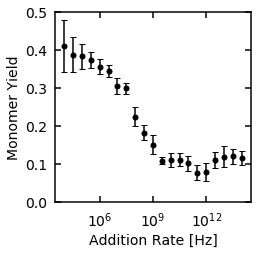

In [19]:
plt.figure(figsize=(3.5,3.5))
plt.errorbar(addrates,av_monYield,yerr = std_monYield,linestyle='none',marker='.',markersize=10,markerfacecolor='black',markeredgecolor='black',capsize=3,ecolor='black')
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('Addition Rate [Hz]',fontsize=14)
plt.ylim([0.0,0.5]);

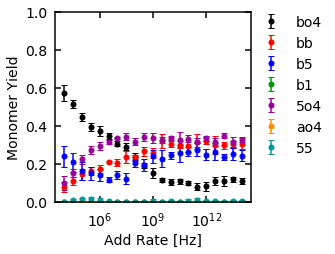

In [20]:
colors = [(0,0,0),(1,0,0),(0,0,1),(0,0.6,0),(0.6,0,0.6),(1,0.5490,0),(0,0.6,0.6),(1,0.8,0),(0.6078,0.2980,0),
         (0.6,0,0),(0,0,0.6)]
plt.figure(figsize=(3.5,3.5))
plt.errorbar(addrates,av_bo4Content,yerr = std_bo4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[0],markeredgecolor=colors[0],label='bo4',capsize=3,ecolor=colors[0])
plt.errorbar(addrates,av_bbContent,yerr = std_bbContent,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[1],markeredgecolor=colors[1],label='bb',capsize=3,ecolor=colors[1])
plt.errorbar(addrates,av_b5Content,yerr = std_b5Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[2],markeredgecolor=colors[2],label='b5',capsize=3,ecolor=colors[2])
plt.errorbar(addrates,av_b1Content,yerr = std_b1Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[3],markeredgecolor=colors[3],label='b1',capsize=3,ecolor=colors[3])
plt.errorbar(addrates,av_5o4Content,yerr = std_5o4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[4],markeredgecolor=colors[4],label='5o4',capsize=3,ecolor=colors[4])
plt.errorbar(addrates,av_ao4Content,yerr = std_ao4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[5],markeredgecolor=colors[5],label='ao4',capsize=3,ecolor=colors[5])
plt.errorbar(addrates,av_55Content,yerr = std_55Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[6],markeredgecolor=colors[6],label='55',capsize=3,ecolor=colors[6])
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('Add Rate [Hz]',fontsize=14)
plt.ylim([0.0,1.0])
plt.legend(fontsize=14,loc='upper center',bbox_to_anchor=(1.2,1.05),frameon=False);

### Continuous SG ratio sensitivity
We will now perform the same task on different SG ratios with a very slow addition rate

In [21]:
sg_opts = [0.1,0.2,0.25,0.33,0.5,1,2,3,4,5,10]

fun = par.delayed(kmc.run)
resultsToSave = []
     
for sg in sg_opts:
    #Set the percentage of S
    pct = sg / (1 + sg)
    
    #Make choices about what kinds of monomers there are
    n = 5
    rands = np.random.rand(n)
    
    #Initialize the monomers, events, and state
    mons = [ kmc.Monomer( int ( sOrG < pct ) , i ) for i,sOrG in zip ( range(n) , rands ) ]
    startEvents = [ kmc.Event ( 'ox' , [i] , rates['ox'][ int( sOrG < pct ) ]['monomer'] ) for i,sOrG in zip ( range(n) , rands) ]

    state = { i : {'mon' : mons[i] , 'affected' : {startEvents[i]} } for i in range(n) }
    events = { startEvents[i] for i in range(n) }
    events.add(kmc.Event('grow',[],rate = 1e4,bond = sg))

    results = par.Parallel(n_jobs = 4)([fun(nMax = 200, tFinal = 1,rates = rates,initialState = state,initialEvents = events)
                                        for _ in range(5)])
    resultsToSave.append(results)
    print('Completed sensitivity iteration: ' + str(sg))

    t = time.localtime()
    print('Finished on ' + str(t.tm_year) + '-' + str(t.tm_mon) + '-' + str(t.tm_mday) 
            + ' at ' + str(t.tm_hour) + ':' + str(t.tm_min) + ':' + str(t.tm_sec))

Completed sensitivity iteration: 0.1
Finished on 2019-12-5 at 11:29:25
Completed sensitivity iteration: 0.2
Finished on 2019-12-5 at 11:29:30
Completed sensitivity iteration: 0.25
Finished on 2019-12-5 at 11:29:33
Completed sensitivity iteration: 0.33
Finished on 2019-12-5 at 11:29:37
Completed sensitivity iteration: 0.5
Finished on 2019-12-5 at 11:29:40
Completed sensitivity iteration: 1
Finished on 2019-12-5 at 11:29:44
Completed sensitivity iteration: 2
Finished on 2019-12-5 at 11:29:49
Completed sensitivity iteration: 3
Finished on 2019-12-5 at 11:29:54
Completed sensitivity iteration: 4
Finished on 2019-12-5 at 11:29:58
Completed sensitivity iteration: 5
Finished on 2019-12-5 at 11:30:3
Completed sensitivity iteration: 10
Finished on 2019-12-5 at 11:30:9


In [22]:
nodeRes = [0]*len(resultsToSave); adjRes = [0]*len(resultsToSave);
analysis = [0]*len(resultsToSave)
for i in range(len(resultsToSave)):
    nodeRes[i] = [resultsToSave[i][j]['monomers'] for j in range(len(resultsToSave[i]))]
    adjRes[i] = [resultsToSave[i][j]['adjacency_matrix'] for j in range(len(resultsToSave[i]))]
    
    analysis[i] = par.Parallel(n_jobs = 4)([par.delayed(kmc.analyze)
                                         (adjacency = adjRes[i][j],
                                          nodes = nodeRes[i][j]) 
                                         for j in range(len(resultsToSave[i]))])
    t = time.localtime()
    print('Finished on ',(str(t.tm_year) + '-' + str(t.tm_mon) + '-' 
                          + str(t.tm_mday)), 'at', 
         (str(t.tm_hour) + ':' + str(t.tm_min) + ':' + str(t.tm_sec)))

Finished on  2019-12-5 at 11:30:12
Finished on  2019-12-5 at 11:30:15
Finished on  2019-12-5 at 11:30:19
Finished on  2019-12-5 at 11:30:22
Finished on  2019-12-5 at 11:30:24
Finished on  2019-12-5 at 11:30:27
Finished on  2019-12-5 at 11:30:30
Finished on  2019-12-5 at 11:30:33
Finished on  2019-12-5 at 11:30:36
Finished on  2019-12-5 at 11:30:40
Finished on  2019-12-5 at 11:30:42


In [23]:
nsens = len(analysis)
nrep = len(analysis[0])

nmon = [[sum([analysis[j][i]['Chain Lengths'][k]*k for k in analysis[j][i]['Chain Lengths']]) 
         for i in range(nrep)] for j in range(nsens)]

monomerYields = [[analysis[j][i]['RCF Yields'][1]/nmon[j][i] 
                  for i in range(nrep)] for j in range(nsens)]
betaO4Content = [[analysis[j][i]['Bonds']['bo4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
beta5Content = [[analysis[j][i]['Bonds']['b5']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
betabetaContent = [[analysis[j][i]['Bonds']['bb']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
beta1Content = [[analysis[j][i]['Bonds']['b1']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
fiveO4Content = [[analysis[j][i]['Bonds']['5o4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
alphaO4Content = [[analysis[j][i]['Bonds']['ao4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
fivefiveContent = [[analysis[j][i]['Bonds']['55']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]

av_monYield = [np.mean(hist) for hist in monomerYields]; std_monYield = [np.sqrt(np.var(hist)) for hist in monomerYields];
av_bo4Content = [np.mean(hist) for hist in betaO4Content]; std_bo4Content = [np.sqrt(np.var(hist)) for hist in betaO4Content];
av_b5Content = [np.mean(hist) for hist in beta5Content]; std_b5Content = [np.sqrt(np.var(hist)) for hist in beta5Content];
av_bbContent = [np.mean(hist) for hist in betabetaContent]; std_bbContent = [np.sqrt(np.var(hist)) for hist in betabetaContent];
av_b1Content = [np.mean(hist) for hist in beta1Content]; std_b1Content = [np.sqrt(np.var(hist)) for hist in beta1Content];
av_5o4Content = [np.mean(hist) for hist in fiveO4Content]; std_5o4Content = [np.sqrt(np.var(hist)) for hist in fiveO4Content];
av_ao4Content = [np.mean(hist) for hist in alphaO4Content]; std_ao4Content = [np.sqrt(np.var(hist)) for hist in alphaO4Content];
av_55Content = [np.mean(hist) for hist in fivefiveContent]; std_55Content = [np.sqrt(np.var(hist)) for hist in fivefiveContent];

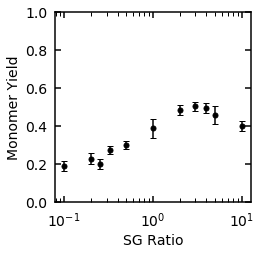

In [24]:
plt.figure(figsize=(3.5,3.5))
plt.errorbar(sg_opts,av_monYield,yerr = std_monYield,linestyle='none',marker='.',markersize=10,markerfacecolor='black',markeredgecolor='black',capsize=3,ecolor='black')
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('SG Ratio',fontsize=14)
plt.ylim([0.0,1.0]);

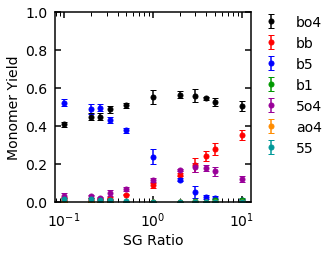

In [25]:
colors = [(0,0,0),(1,0,0),(0,0,1),(0,0.6,0),(0.6,0,0.6),(1,0.5490,0),(0,0.6,0.6),(1,0.8,0),(0.6078,0.2980,0),
         (0.6,0,0),(0,0,0.6)]
plt.figure(figsize=(3.5,3.5))
plt.errorbar(sg_opts,av_bo4Content,yerr = std_bo4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[0],markeredgecolor=colors[0],label='bo4',capsize=3,ecolor=colors[0])
plt.errorbar(sg_opts,av_bbContent,yerr = std_bbContent,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[1],markeredgecolor=colors[1],label='bb',capsize=3,ecolor=colors[1])
plt.errorbar(sg_opts,av_b5Content,yerr = std_b5Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[2],markeredgecolor=colors[2],label='b5',capsize=3,ecolor=colors[2])
plt.errorbar(sg_opts,av_b1Content,yerr = std_b1Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[3],markeredgecolor=colors[3],label='b1',capsize=3,ecolor=colors[3])
plt.errorbar(sg_opts,av_5o4Content,yerr = std_5o4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[4],markeredgecolor=colors[4],label='5o4',capsize=3,ecolor=colors[4])
plt.errorbar(sg_opts,av_ao4Content,yerr = std_ao4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[5],markeredgecolor=colors[5],label='ao4',capsize=3,ecolor=colors[5])
plt.errorbar(sg_opts,av_55Content,yerr = std_55Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[6],markeredgecolor=colors[6],label='55',capsize=3,ecolor=colors[6])
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('SG Ratio',fontsize=14)
plt.ylim([0.0,1.0])
plt.legend(fontsize=14,loc='upper center',bbox_to_anchor=(1.2,1.05),frameon=False);

### Continuous SG ratio sensitivity 1e7 Hz
We will now perform the same task on different SG ratios with three different addition rates

In [26]:
sg_opts = [0.1,0.2,0.25,0.33,0.5,1,2,3,4,5,10]

fun = par.delayed(kmc.run)
resultsToSave = []
     
for sg in sg_opts:
    #Set the percentage of S
    pct = sg / (1 + sg)
    
    #Make choices about what kinds of monomers there are
    n = 5
    rands = np.random.rand(n)
    
    #Initialize the monomers, events, and state
    mons = [ kmc.Monomer( int ( sOrG < pct ) , i ) for i,sOrG in zip ( range(n) , rands ) ]
    startEvents = [ kmc.Event ( 'ox' , [i] , rates['ox'][ int( sOrG < pct ) ]['monomer'] ) for i,sOrG in zip ( range(n) , rands) ]

    state = { i : {'mon' : mons[i] , 'affected' : {startEvents[i]} } for i in range(n) }
    events = { startEvents[i] for i in range(n) }
    events.add(kmc.Event('grow',[],rate = 1e7,bond = sg))

    results = par.Parallel(n_jobs = 4)([fun(nMax = 200, tFinal = 1,rates = rates,initialState = state,initialEvents = events)
                                        for _ in range(5)])
    resultsToSave.append(results)
    print('Completed sensitivity iteration: ' + str(sg))

    t = time.localtime()
    print('Finished on ' + str(t.tm_year) + '-' + str(t.tm_mon) + '-' + str(t.tm_mday) 
            + ' at ' + str(t.tm_hour) + ':' + str(t.tm_min) + ':' + str(t.tm_sec))

Completed sensitivity iteration: 0.1
Finished on 2019-12-5 at 11:30:50
Completed sensitivity iteration: 0.2
Finished on 2019-12-5 at 11:30:57
Completed sensitivity iteration: 0.25
Finished on 2019-12-5 at 11:31:11
Completed sensitivity iteration: 0.33
Finished on 2019-12-5 at 11:31:21
Completed sensitivity iteration: 0.5
Finished on 2019-12-5 at 11:31:50
Completed sensitivity iteration: 1
Finished on 2019-12-5 at 11:33:29
Completed sensitivity iteration: 2
Finished on 2019-12-5 at 11:33:50
Completed sensitivity iteration: 3
Finished on 2019-12-5 at 11:34:4
Completed sensitivity iteration: 4
Finished on 2019-12-5 at 11:34:18
Completed sensitivity iteration: 5
Finished on 2019-12-5 at 11:34:31
Completed sensitivity iteration: 10
Finished on 2019-12-5 at 11:34:42


In [27]:
nodeRes = [0]*len(resultsToSave); adjRes = [0]*len(resultsToSave);
analysis = [0]*len(resultsToSave)
for i in range(len(resultsToSave)):
    nodeRes[i] = [resultsToSave[i][j]['monomers'] for j in range(len(resultsToSave[i]))]
    adjRes[i] = [resultsToSave[i][j]['adjacency_matrix'] for j in range(len(resultsToSave[i]))]
    
    analysis[i] = par.Parallel(n_jobs = 4)([par.delayed(kmc.analyze)
                                         (adjacency = adjRes[i][j],
                                          nodes = nodeRes[i][j]) 
                                         for j in range(len(resultsToSave[i]))])
    t = time.localtime()
    print('Finished on ',(str(t.tm_year) + '-' + str(t.tm_mon) + '-' 
                          + str(t.tm_mday)), 'at', 
         (str(t.tm_hour) + ':' + str(t.tm_min) + ':' + str(t.tm_sec)))

Finished on  2019-12-5 at 11:34:45
Finished on  2019-12-5 at 11:34:49
Finished on  2019-12-5 at 11:34:52
Finished on  2019-12-5 at 11:34:55
Finished on  2019-12-5 at 11:34:58
Finished on  2019-12-5 at 11:35:1
Finished on  2019-12-5 at 11:35:3
Finished on  2019-12-5 at 11:35:6
Finished on  2019-12-5 at 11:35:9
Finished on  2019-12-5 at 11:35:11
Finished on  2019-12-5 at 11:35:14


In [28]:
nsens = len(analysis)
nrep = len(analysis[0])

nmon = [[sum([analysis[j][i]['Chain Lengths'][k]*k for k in analysis[j][i]['Chain Lengths']]) 
         for i in range(nrep)] for j in range(nsens)]

monomerYields = [[analysis[j][i]['RCF Yields'][1]/nmon[j][i] 
                  for i in range(nrep)] for j in range(nsens)]
betaO4Content = [[analysis[j][i]['Bonds']['bo4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
beta5Content = [[analysis[j][i]['Bonds']['b5']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
betabetaContent = [[analysis[j][i]['Bonds']['bb']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
beta1Content = [[analysis[j][i]['Bonds']['b1']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
fiveO4Content = [[analysis[j][i]['Bonds']['5o4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
alphaO4Content = [[analysis[j][i]['Bonds']['ao4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
fivefiveContent = [[analysis[j][i]['Bonds']['55']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]

av_monYield = [np.mean(hist) for hist in monomerYields]; std_monYield = [np.sqrt(np.var(hist)) for hist in monomerYields];
av_bo4Content = [np.mean(hist) for hist in betaO4Content]; std_bo4Content = [np.sqrt(np.var(hist)) for hist in betaO4Content];
av_b5Content = [np.mean(hist) for hist in beta5Content]; std_b5Content = [np.sqrt(np.var(hist)) for hist in beta5Content];
av_bbContent = [np.mean(hist) for hist in betabetaContent]; std_bbContent = [np.sqrt(np.var(hist)) for hist in betabetaContent];
av_b1Content = [np.mean(hist) for hist in beta1Content]; std_b1Content = [np.sqrt(np.var(hist)) for hist in beta1Content];
av_5o4Content = [np.mean(hist) for hist in fiveO4Content]; std_5o4Content = [np.sqrt(np.var(hist)) for hist in fiveO4Content];
av_ao4Content = [np.mean(hist) for hist in alphaO4Content]; std_ao4Content = [np.sqrt(np.var(hist)) for hist in alphaO4Content];
av_55Content = [np.mean(hist) for hist in fivefiveContent]; std_55Content = [np.sqrt(np.var(hist)) for hist in fivefiveContent];

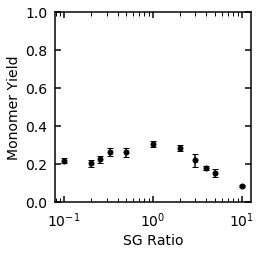

In [29]:
plt.figure(figsize=(3.5,3.5))
plt.errorbar(sg_opts,av_monYield,yerr = std_monYield,linestyle='none',marker='.',markersize=10,markerfacecolor='black',markeredgecolor='black',capsize=3,ecolor='black')
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('SG Ratio',fontsize=14)
plt.ylim([0.0,1.0]);

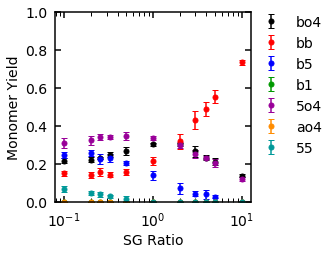

In [30]:
colors = [(0,0,0),(1,0,0),(0,0,1),(0,0.6,0),(0.6,0,0.6),(1,0.5490,0),(0,0.6,0.6),(1,0.8,0),(0.6078,0.2980,0),
         (0.6,0,0),(0,0,0.6)]
plt.figure(figsize=(3.5,3.5))
plt.errorbar(sg_opts,av_bo4Content,yerr = std_bo4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[0],markeredgecolor=colors[0],label='bo4',capsize=3,ecolor=colors[0])
plt.errorbar(sg_opts,av_bbContent,yerr = std_bbContent,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[1],markeredgecolor=colors[1],label='bb',capsize=3,ecolor=colors[1])
plt.errorbar(sg_opts,av_b5Content,yerr = std_b5Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[2],markeredgecolor=colors[2],label='b5',capsize=3,ecolor=colors[2])
plt.errorbar(sg_opts,av_b1Content,yerr = std_b1Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[3],markeredgecolor=colors[3],label='b1',capsize=3,ecolor=colors[3])
plt.errorbar(sg_opts,av_5o4Content,yerr = std_5o4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[4],markeredgecolor=colors[4],label='5o4',capsize=3,ecolor=colors[4])
plt.errorbar(sg_opts,av_ao4Content,yerr = std_ao4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[5],markeredgecolor=colors[5],label='ao4',capsize=3,ecolor=colors[5])
plt.errorbar(sg_opts,av_55Content,yerr = std_55Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[6],markeredgecolor=colors[6],label='55',capsize=3,ecolor=colors[6])
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('SG Ratio',fontsize=14)
plt.ylim([0.0,1.0])
plt.legend(fontsize=14,loc='upper center',bbox_to_anchor=(1.2,1.05),frameon=False);

### Continuous SG ratio sensitivity 1e9 Hz
We will now perform the same task on different SG ratios with three different addition rates

In [31]:
sg_opts = [0.1,0.2,0.25,0.33,0.5,1,2,3,4,5,10]

fun = par.delayed(kmc.run)
resultsToSave = []
     
for sg in sg_opts:
    #Set the percentage of S
    pct = sg / (1 + sg)
    
    #Make choices about what kinds of monomers there are
    n = 5
    rands = np.random.rand(n)
    
    #Initialize the monomers, events, and state
    mons = [ kmc.Monomer( int ( sOrG < pct ) , i ) for i,sOrG in zip ( range(n) , rands ) ]
    startEvents = [ kmc.Event ( 'ox' , [i] , rates['ox'][ int( sOrG < pct ) ]['monomer'] ) for i,sOrG in zip ( range(n) , rands) ]

    state = { i : {'mon' : mons[i] , 'affected' : {startEvents[i]} } for i in range(n) }
    events = { startEvents[i] for i in range(n) }
    events.add(kmc.Event('grow',[],rate = 1e9,bond = sg))

    results = par.Parallel(n_jobs = 4)([fun(nMax = 200, tFinal = 1,rates = rates,initialState = state,initialEvents = events)
                                        for _ in range(5)])
    resultsToSave.append(results)
    print('Completed sensitivity iteration: ' + str(sg))

    t = time.localtime()
    print('Finished on ' + str(t.tm_year) + '-' + str(t.tm_mon) + '-' + str(t.tm_mday) 
            + ' at ' + str(t.tm_hour) + ':' + str(t.tm_min) + ':' + str(t.tm_sec))

Completed sensitivity iteration: 0.1
Finished on 2019-12-5 at 11:35:29
Completed sensitivity iteration: 0.2
Finished on 2019-12-5 at 11:35:42
Completed sensitivity iteration: 0.25
Finished on 2019-12-5 at 11:35:56
Completed sensitivity iteration: 0.33
Finished on 2019-12-5 at 11:36:8
Completed sensitivity iteration: 0.5
Finished on 2019-12-5 at 11:36:22
Completed sensitivity iteration: 1
Finished on 2019-12-5 at 11:36:38
Completed sensitivity iteration: 2
Finished on 2019-12-5 at 11:36:53
Completed sensitivity iteration: 3
Finished on 2019-12-5 at 11:37:9
Completed sensitivity iteration: 4
Finished on 2019-12-5 at 11:37:24
Completed sensitivity iteration: 5
Finished on 2019-12-5 at 11:37:39
Completed sensitivity iteration: 10
Finished on 2019-12-5 at 11:37:54


In [32]:
nodeRes = [0]*len(resultsToSave); adjRes = [0]*len(resultsToSave);
analysis = [0]*len(resultsToSave)
for i in range(len(resultsToSave)):
    nodeRes[i] = [resultsToSave[i][j]['monomers'] for j in range(len(resultsToSave[i]))]
    adjRes[i] = [resultsToSave[i][j]['adjacency_matrix'] for j in range(len(resultsToSave[i]))]
    
    analysis[i] = par.Parallel(n_jobs = 4)([par.delayed(kmc.analyze)
                                         (adjacency = adjRes[i][j],
                                          nodes = nodeRes[i][j]) 
                                         for j in range(len(resultsToSave[i]))])
    t = time.localtime()
    print('Finished on ',(str(t.tm_year) + '-' + str(t.tm_mon) + '-' 
                          + str(t.tm_mday)), 'at', 
         (str(t.tm_hour) + ':' + str(t.tm_min) + ':' + str(t.tm_sec)))

Finished on  2019-12-5 at 11:37:56
Finished on  2019-12-5 at 11:37:59
Finished on  2019-12-5 at 11:38:1
Finished on  2019-12-5 at 11:38:4
Finished on  2019-12-5 at 11:38:7
Finished on  2019-12-5 at 11:38:9
Finished on  2019-12-5 at 11:38:11
Finished on  2019-12-5 at 11:38:14
Finished on  2019-12-5 at 11:38:16
Finished on  2019-12-5 at 11:38:18
Finished on  2019-12-5 at 11:38:20


In [33]:
nsens = len(analysis)
nrep = len(analysis[0])

nmon = [[sum([analysis[j][i]['Chain Lengths'][k]*k for k in analysis[j][i]['Chain Lengths']]) 
         for i in range(nrep)] for j in range(nsens)]

monomerYields = [[analysis[j][i]['RCF Yields'][1]/nmon[j][i] 
                  for i in range(nrep)] for j in range(nsens)]
betaO4Content = [[analysis[j][i]['Bonds']['bo4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
beta5Content = [[analysis[j][i]['Bonds']['b5']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
betabetaContent = [[analysis[j][i]['Bonds']['bb']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
beta1Content = [[analysis[j][i]['Bonds']['b1']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
fiveO4Content = [[analysis[j][i]['Bonds']['5o4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
alphaO4Content = [[analysis[j][i]['Bonds']['ao4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
fivefiveContent = [[analysis[j][i]['Bonds']['55']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]

av_monYield = [np.mean(hist) for hist in monomerYields]; std_monYield = [np.sqrt(np.var(hist)) for hist in monomerYields];
av_bo4Content = [np.mean(hist) for hist in betaO4Content]; std_bo4Content = [np.sqrt(np.var(hist)) for hist in betaO4Content];
av_b5Content = [np.mean(hist) for hist in beta5Content]; std_b5Content = [np.sqrt(np.var(hist)) for hist in beta5Content];
av_bbContent = [np.mean(hist) for hist in betabetaContent]; std_bbContent = [np.sqrt(np.var(hist)) for hist in betabetaContent];
av_b1Content = [np.mean(hist) for hist in beta1Content]; std_b1Content = [np.sqrt(np.var(hist)) for hist in beta1Content];
av_5o4Content = [np.mean(hist) for hist in fiveO4Content]; std_5o4Content = [np.sqrt(np.var(hist)) for hist in fiveO4Content];
av_ao4Content = [np.mean(hist) for hist in alphaO4Content]; std_ao4Content = [np.sqrt(np.var(hist)) for hist in alphaO4Content];
av_55Content = [np.mean(hist) for hist in fivefiveContent]; std_55Content = [np.sqrt(np.var(hist)) for hist in fivefiveContent];

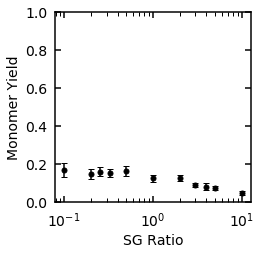

In [34]:
plt.figure(figsize=(3.5,3.5))
plt.errorbar(sg_opts,av_monYield,yerr = std_monYield,linestyle='none',marker='.',markersize=10,markerfacecolor='black',markeredgecolor='black',capsize=3,ecolor='black')
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('SG Ratio',fontsize=14)
plt.ylim([0.0,1.0]);

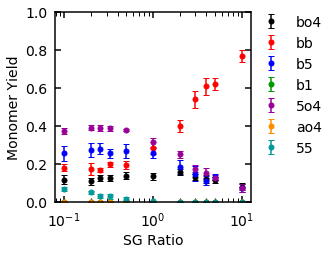

In [35]:
colors = [(0,0,0),(1,0,0),(0,0,1),(0,0.6,0),(0.6,0,0.6),(1,0.5490,0),(0,0.6,0.6),(1,0.8,0),(0.6078,0.2980,0),
         (0.6,0,0),(0,0,0.6)]
plt.figure(figsize=(3.5,3.5))
plt.errorbar(sg_opts,av_bo4Content,yerr = std_bo4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[0],markeredgecolor=colors[0],label='bo4',capsize=3,ecolor=colors[0])
plt.errorbar(sg_opts,av_bbContent,yerr = std_bbContent,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[1],markeredgecolor=colors[1],label='bb',capsize=3,ecolor=colors[1])
plt.errorbar(sg_opts,av_b5Content,yerr = std_b5Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[2],markeredgecolor=colors[2],label='b5',capsize=3,ecolor=colors[2])
plt.errorbar(sg_opts,av_b1Content,yerr = std_b1Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[3],markeredgecolor=colors[3],label='b1',capsize=3,ecolor=colors[3])
plt.errorbar(sg_opts,av_5o4Content,yerr = std_5o4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[4],markeredgecolor=colors[4],label='5o4',capsize=3,ecolor=colors[4])
plt.errorbar(sg_opts,av_ao4Content,yerr = std_ao4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[5],markeredgecolor=colors[5],label='ao4',capsize=3,ecolor=colors[5])
plt.errorbar(sg_opts,av_55Content,yerr = std_55Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[6],markeredgecolor=colors[6],label='55',capsize=3,ecolor=colors[6])
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('SG Ratio',fontsize=14)
plt.ylim([0.0,1.0])
plt.legend(fontsize=14,loc='upper center',bbox_to_anchor=(1.2,1.05),frameon=False);

### Continuous SG ratio sensitivity 1e11 Hz
We will now perform the same task on different SG ratios with three different addition rates

In [36]:
sg_opts = [0.1,0.2,0.25,0.33,0.5,1,2,3,4,5,10]

fun = par.delayed(kmc.run)
resultsToSave = []
     
for sg in sg_opts:
    #Set the percentage of S
    pct = sg / (1 + sg)
    
    #Make choices about what kinds of monomers there are
    n = 5
    rands = np.random.rand(n)
    
    #Initialize the monomers, events, and state
    mons = [ kmc.Monomer( int ( sOrG < pct ) , i ) for i,sOrG in zip ( range(n) , rands ) ]
    startEvents = [ kmc.Event ( 'ox' , [i] , rates['ox'][ int( sOrG < pct ) ]['monomer'] ) for i,sOrG in zip ( range(n) , rands) ]

    state = { i : {'mon' : mons[i] , 'affected' : {startEvents[i]} } for i in range(n) }
    events = { startEvents[i] for i in range(n) }
    events.add(kmc.Event('grow',[],rate = 1e11,bond = sg))

    results = par.Parallel(n_jobs = 4)([fun(nMax = 200, tFinal = 1,rates = rates,initialState = state,initialEvents = events)
                                        for _ in range(5)])
    resultsToSave.append(results)
    print('Completed sensitivity iteration: ' + str(sg))

    t = time.localtime()
    print('Finished on ' + str(t.tm_year) + '-' + str(t.tm_mon) + '-' + str(t.tm_mday) 
            + ' at ' + str(t.tm_hour) + ':' + str(t.tm_min) + ':' + str(t.tm_sec))

Completed sensitivity iteration: 0.1
Finished on 2019-12-5 at 11:39:37
Completed sensitivity iteration: 0.2
Finished on 2019-12-5 at 11:40:53
Completed sensitivity iteration: 0.25
Finished on 2019-12-5 at 11:42:13
Completed sensitivity iteration: 0.33
Finished on 2019-12-5 at 11:43:29
Completed sensitivity iteration: 0.5
Finished on 2019-12-5 at 11:44:55
Completed sensitivity iteration: 1
Finished on 2019-12-5 at 11:46:18
Completed sensitivity iteration: 2
Finished on 2019-12-5 at 11:47:26
Completed sensitivity iteration: 3
Finished on 2019-12-5 at 11:48:40
Completed sensitivity iteration: 4
Finished on 2019-12-5 at 11:49:41
Completed sensitivity iteration: 5
Finished on 2019-12-5 at 11:51:2
Completed sensitivity iteration: 10
Finished on 2019-12-5 at 11:52:10


In [37]:
nodeRes = [0]*len(resultsToSave); adjRes = [0]*len(resultsToSave);
analysis = [0]*len(resultsToSave)
for i in range(len(resultsToSave)):
    nodeRes[i] = [resultsToSave[i][j]['monomers'] for j in range(len(resultsToSave[i]))]
    adjRes[i] = [resultsToSave[i][j]['adjacency_matrix'] for j in range(len(resultsToSave[i]))]
    
    analysis[i] = par.Parallel(n_jobs = 4)([par.delayed(kmc.analyze)
                                         (adjacency = adjRes[i][j],
                                          nodes = nodeRes[i][j]) 
                                         for j in range(len(resultsToSave[i]))])
    t = time.localtime()
    print('Finished on ',(str(t.tm_year) + '-' + str(t.tm_mon) + '-' 
                          + str(t.tm_mday)), 'at', 
         (str(t.tm_hour) + ':' + str(t.tm_min) + ':' + str(t.tm_sec)))

Finished on  2019-12-5 at 11:52:12
Finished on  2019-12-5 at 11:52:14
Finished on  2019-12-5 at 11:52:17
Finished on  2019-12-5 at 11:52:20
Finished on  2019-12-5 at 11:52:23
Finished on  2019-12-5 at 11:52:26
Finished on  2019-12-5 at 11:52:29
Finished on  2019-12-5 at 11:52:31
Finished on  2019-12-5 at 11:52:34
Finished on  2019-12-5 at 11:52:36
Finished on  2019-12-5 at 11:52:39


In [38]:
nsens = len(analysis)
nrep = len(analysis[0])

nmon = [[sum([analysis[j][i]['Chain Lengths'][k]*k for k in analysis[j][i]['Chain Lengths']]) 
         for i in range(nrep)] for j in range(nsens)]

monomerYields = [[analysis[j][i]['RCF Yields'][1]/nmon[j][i] 
                  for i in range(nrep)] for j in range(nsens)]
betaO4Content = [[analysis[j][i]['Bonds']['bo4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
beta5Content = [[analysis[j][i]['Bonds']['b5']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
betabetaContent = [[analysis[j][i]['Bonds']['bb']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
beta1Content = [[analysis[j][i]['Bonds']['b1']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
fiveO4Content = [[analysis[j][i]['Bonds']['5o4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
alphaO4Content = [[analysis[j][i]['Bonds']['ao4']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]
fivefiveContent = [[analysis[j][i]['Bonds']['55']/sum(analysis[j][i]['Bonds'].values())
                 for i in range(nrep)] for j in range(nsens)]

av_monYield = [np.mean(hist) for hist in monomerYields]; std_monYield = [np.sqrt(np.var(hist)) for hist in monomerYields];
av_bo4Content = [np.mean(hist) for hist in betaO4Content]; std_bo4Content = [np.sqrt(np.var(hist)) for hist in betaO4Content];
av_b5Content = [np.mean(hist) for hist in beta5Content]; std_b5Content = [np.sqrt(np.var(hist)) for hist in beta5Content];
av_bbContent = [np.mean(hist) for hist in betabetaContent]; std_bbContent = [np.sqrt(np.var(hist)) for hist in betabetaContent];
av_b1Content = [np.mean(hist) for hist in beta1Content]; std_b1Content = [np.sqrt(np.var(hist)) for hist in beta1Content];
av_5o4Content = [np.mean(hist) for hist in fiveO4Content]; std_5o4Content = [np.sqrt(np.var(hist)) for hist in fiveO4Content];
av_ao4Content = [np.mean(hist) for hist in alphaO4Content]; std_ao4Content = [np.sqrt(np.var(hist)) for hist in alphaO4Content];
av_55Content = [np.mean(hist) for hist in fivefiveContent]; std_55Content = [np.sqrt(np.var(hist)) for hist in fivefiveContent];

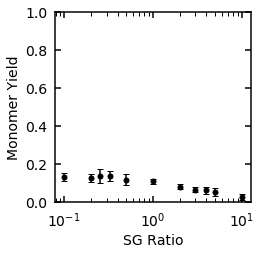

In [39]:
plt.figure(figsize=(3.5,3.5))
plt.errorbar(sg_opts,av_monYield,yerr = std_monYield,linestyle='none',marker='.',markersize=10,markerfacecolor='black',markeredgecolor='black',capsize=3,ecolor='black')
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('SG Ratio',fontsize=14)
plt.ylim([0.0,1.0]);

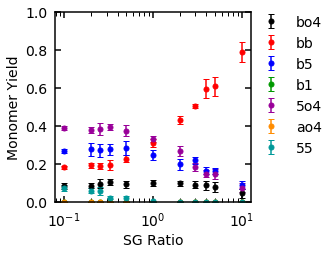

In [40]:
colors = [(0,0,0),(1,0,0),(0,0,1),(0,0.6,0),(0.6,0,0.6),(1,0.5490,0),(0,0.6,0.6),(1,0.8,0),(0.6078,0.2980,0),
         (0.6,0,0),(0,0,0.6)]
plt.figure(figsize=(3.5,3.5))
plt.errorbar(sg_opts,av_bo4Content,yerr = std_bo4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[0],markeredgecolor=colors[0],label='bo4',capsize=3,ecolor=colors[0])
plt.errorbar(sg_opts,av_bbContent,yerr = std_bbContent,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[1],markeredgecolor=colors[1],label='bb',capsize=3,ecolor=colors[1])
plt.errorbar(sg_opts,av_b5Content,yerr = std_b5Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[2],markeredgecolor=colors[2],label='b5',capsize=3,ecolor=colors[2])
plt.errorbar(sg_opts,av_b1Content,yerr = std_b1Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[3],markeredgecolor=colors[3],label='b1',capsize=3,ecolor=colors[3])
plt.errorbar(sg_opts,av_5o4Content,yerr = std_5o4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[4],markeredgecolor=colors[4],label='5o4',capsize=3,ecolor=colors[4])
plt.errorbar(sg_opts,av_ao4Content,yerr = std_ao4Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[5],markeredgecolor=colors[5],label='ao4',capsize=3,ecolor=colors[5])
plt.errorbar(sg_opts,av_55Content,yerr = std_55Content,linestyle='none',marker='.',markersize=10,markerfacecolor=colors[6],markeredgecolor=colors[6],label='55',capsize=3,ecolor=colors[6])
plt.xscale('log')
[plt.gca().spines[i].set_linewidth(1.5) for i in ['top','right','bottom','left']]
plt.gca().tick_params(axis = 'both',which = 'major', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1.5,length=6)
plt.gca().tick_params(axis = 'both',which = 'minor', labelsize = 14, direction = 'in', pad = 8, top = True, right = True, width = 1,length=4)
plt.ylabel('Monomer Yield',fontsize=14)
plt.xlabel('SG Ratio',fontsize=14)
plt.ylim([0.0,1.0])
plt.legend(fontsize=14,loc='upper center',bbox_to_anchor=(1.2,1.05),frameon=False);